# Procesamiento Básico de Señal Digital para Relés

Trabajo presentado por: 
- Andrés Enrique Avila Rojas
- Carlos Salomón Saenz Díaz
- Alberto Bérmudes Arias
- Valentina Reyes Martínez

In [1]:
# Modulos necesarios
import numpy as np
from scipy import signal, fftpack
from matplotlib import pyplot as plt
from scipy.io import loadmat
import cmath 

## Definición de métodos a Utilizar

A continuación se definen las funciones para el cálculo completo de las etapas del procesamiento digital de la señal para un relé.

### Etapa de submuestreo

Se muestrea a la frecuencia de muestro del relé estipulada por el usuario

In [2]:
def subsampling(time,data,fs,fk,fs_user_cycle):
    # time is the vector of time
    # data is the vector with the signal
    # fs_comtrade is the sample rate from the comtrade file
    # fk is the frequency of the system
    # fs_user_cycle is the sample rate given by user
    N1 = fs_user_cycle
    fs_cycle = fs/fk
    N=np.int(fs_cycle)
    N_tot = np.int(len(data)/fs_cycle)
    new_data = [0]
    new_time = [0]
    for i in np.arange(N_tot):
        xi=data[i*N:i*N+N]
        ti=time[i*N:i*N+N]
        new_data[i*N1:i*N1+N1] = signal.resample(xi, N1)
        new_time[i*N1:i*N1+N1] = np.linspace(ti[0], ti[-1], N1, endpoint=False)
        
    return (new_time,new_data)

### Modulo de S&H y A/D (Quantizer)

Método para digitalizar la señal de entrada

In [3]:
def quantizer(data, quantizing_bits):
    # data is the vector with the signal
    # quantizing_bits is the number of bits for the converter
    # Quantizer - S&H and ADC
    quantizing_levels   = 2 ** quantizing_bits
    quantizing_step     = (np.max(data)-np.min(data)) / quantizing_levels
    quantizing_signal   = np.round (data / quantizing_step) * quantizing_step;
    
    return quantizing_signal

### Transformada de Fourier (Filtro de componentes ortogonales basado en filtro coseno)

Se presenta la transformada directa de Fourier con el ventaneo de la señal, teniendo la siguiente representación en componentes ortogonales.

$$X_c = \frac{2}{N}\sum_{k=0}^{N-1} x_k \cos \left(\frac{2\pi}{N} k \right)$$

$$X_s = \frac{2}{N}\sum_{k=0}^{N-1} x_k \sin \left(\frac{2\pi}{N} k \right)$$

In [4]:
def DFT(time, data, fk, fs_user_cycle):
    # time is the vector of time
    # data is the vector with the signal
    # fk is the frequency of the system
    # fs_user_cycle is the sample rate given by user
    
    N=np.int(fs_user_cycle)
    N_tot = len(data)-N
    Xc = [0]*N_tot
    Xs = [0]*N_tot
    t = [0]*N_tot
    
    # Ciclo para el ventaneo
    for i in np.arange(N_tot):
        xi=data[i:i+N]
        t[i]=time[i]
        Xc_sum = 0
        Xs_sum = 0
        # Ciclo para el filtro coseno
        for k in np.arange(N):
            Xc_temp=xi[k]*np.cos(2*np.pi*k/(N))
            Xc_sum=Xc_sum+Xc_temp
            Xs_temp=xi[k]*np.sin(2*np.pi*k/(N))
            Xs_sum=Xs_sum+Xs_temp
            
        Xc[i]= 2/(N*np.sqrt(2))*Xc_sum
        Xs[i]= -2/(N*np.sqrt(2))* Xs_sum
        
    return t, Xc, Xs

## Obtención de Salidas del Programa (Gráficas y lectura de datos)

### Se obtienen y grafican los datos del archivo .mat

Se debe hacer una conversión de la versión obtenida de ATP a una versión -v7 (Ver Change_version.m)

Record has 300001 samples
Sampling rate is 1000000 samples/sec.


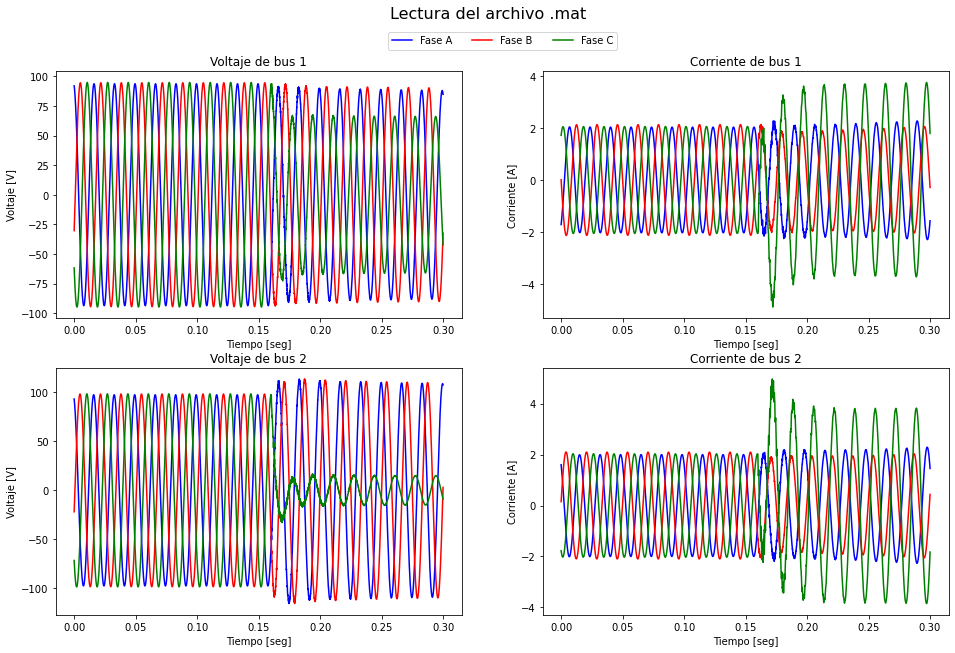

In [5]:
mat = loadmat('Falla_CG_120%_001ohm.mat') # El archivo se selecciona desde la interfaz

# Reading time vector:
time = mat['t'] #Se conoce que todos los archivos vendrán con este vector incluido

N = len(time)
fs = np.int(np.ceil(len(time)/time[-1])-4)

print('Record has {} samples'.format(N))
print('Sampling rate is {} samples/sec.'.format(fs))


# Line frequency in Hz
fk = 60 # It can be set automatically


# Reading voltaje and currents
voltages_bus1 = np.empty(([len(time),3]))
currents_bus1 = np.empty(([len(time),3]))

voltages_bus2 = np.empty(([len(time),3]))
currents_bus2 = np.empty(([len(time),3]))

# Primary side
#Trafo_p =
#Trafo_s =
ratio_V = 1

col=0
for i in ['a','b','c']:
    voltages_bus1[:,col] = mat['vVt1'+i].ravel()
    currents_bus1[:,col] = mat['iCt1'+i].ravel()
    voltages_bus2[:,col] = mat['vVt2'+i].ravel()
    currents_bus2[:,col] = mat['iCt2'+i].ravel()
    col=col+1
    
measures = [voltages_bus1,currents_bus1,voltages_bus2,currents_bus2]
#print(N_tot)
            
f, axarr = plt.subplots(2, 2, figsize =(16, 10))
f.suptitle('Lectura del archivo .mat', y=0.97, fontsize=16)
labels = ['Fase A', 'Fase B', 'Fase C']

n_bus=1
for i in range(len(measures)):
    if (i % 2)==0: #Si es par
        p1 = np.int(i/2)
        p2 = 0
        axarr[p1,p2].set_title(('Voltaje de bus '+str(n_bus)))
        axarr[p1,p2].set_ylabel('Voltaje [V]')
    else:
        p1 = np.int(np.ceil(i/2)-1)
        p2 = 1
        axarr[p1,p2].set_title(('Corriente de bus '+str(n_bus)))
        axarr[p1,p2].set_ylabel('Corriente [A]')
        n_bus=n_bus+1
        
    axarr[p1,p2].set_xlabel('Tiempo [seg]')
    axarr[p1,p2].plot(time, measures[i][:,0], 'b-', label='Fase A')
    axarr[p1,p2].plot(time, measures[i][:,1], 'r-', label='Fase B')
    axarr[p1,p2].plot(time, measures[i][:,2], 'g-', label='Fase C')

f.legend(axarr[1,1].get_lines(), labels, ncol=3, bbox_to_anchor=(0.54, 0.87))

Ejemplo con Falla Bifásica entre B y C.

### Etapa de Submuestreo de las Señales

En este caso, se submuestrea a 16 muestras/ciclo, típicamente es valor se toma teniendo en cuenta lo definido por el usuario en la interfaz.

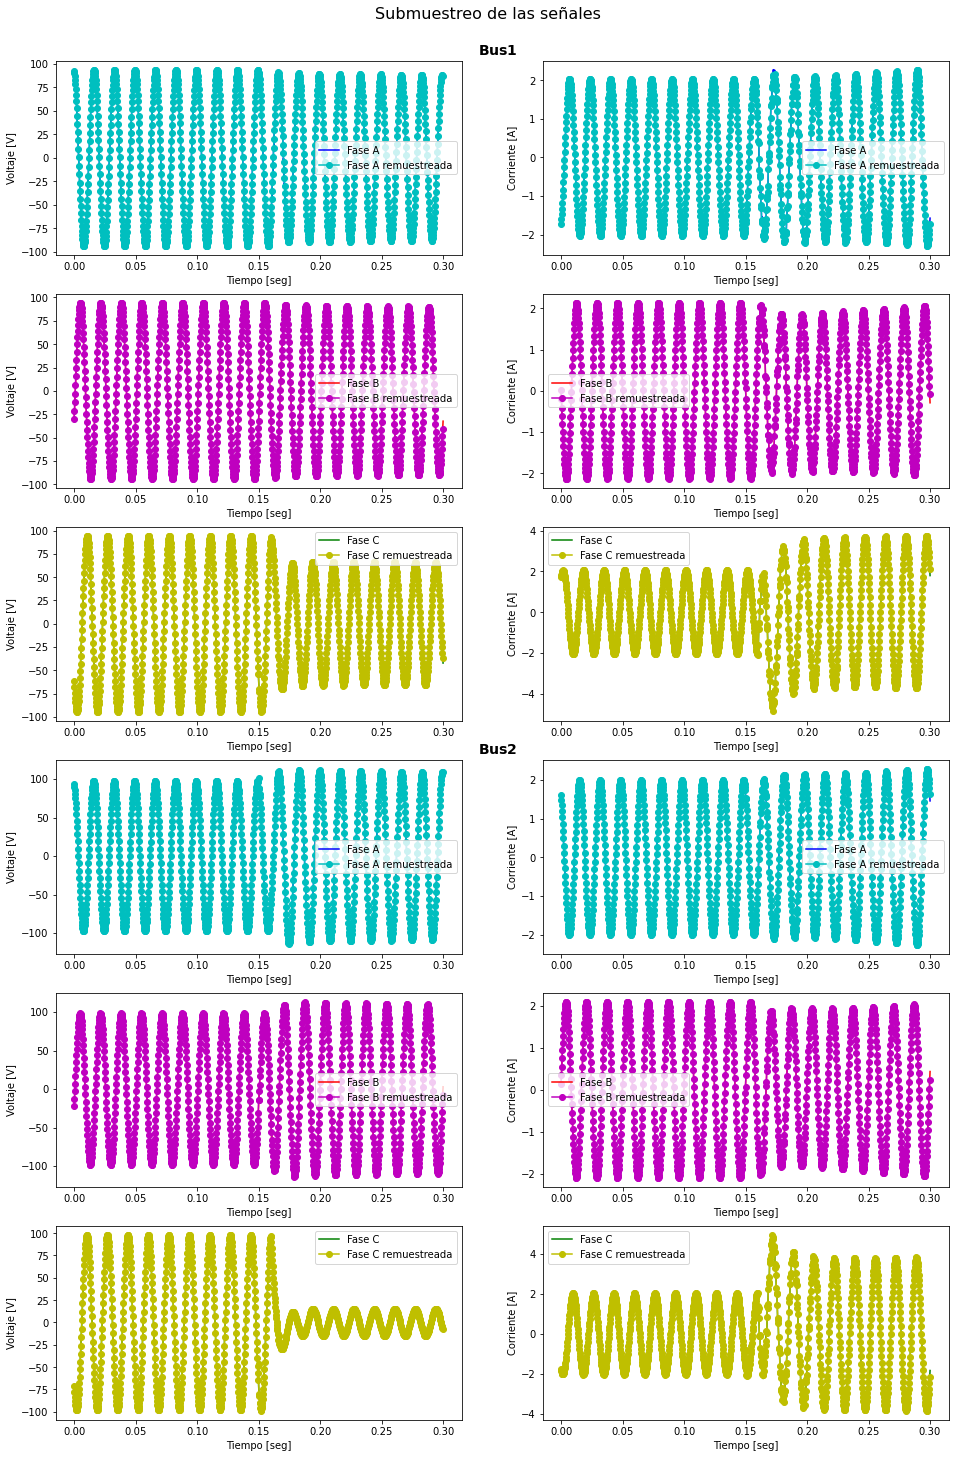

In [6]:
# Subsampling voltaje and currents
fs_user_cycle = 64 # ESTA DATO VIENE DE LA INTERFAZ
N_tot = np.int(N*fk/fs)*fs_user_cycle
V_bus1_sub = np.empty(([N_tot,3]))
I_bus1_sub = np.empty(([N_tot,3]))
V_bus2_sub = np.empty(([N_tot,3]))
I_bus2_sub = np.empty(([N_tot,3]))
time_sub = np.empty(([N_tot,6]))
for i in np.arange(6):
    if i<3:
        time_sub[:,i], V_bus1_sub[:,i] = subsampling(time,voltages_bus1[:,i],fs,fk,fs_user_cycle)
        time_sub[:,i], V_bus2_sub[:,i] = subsampling(time,voltages_bus2[:,i],fs,fk,fs_user_cycle)
    else:
        time_sub[:,i], I_bus1_sub[:,i-3] = subsampling(time,currents_bus1[:,i-3],fs,fk,fs_user_cycle)
        time_sub[:,i], I_bus2_sub[:,i-3] = subsampling(time,currents_bus2[:,i-3],fs,fk,fs_user_cycle)

measures_sub = [V_bus1_sub,I_bus1_sub,V_bus2_sub,I_bus2_sub]
# PLOTING -----------------------------------------------------------------
f, axarr = plt.subplots(6, 2, figsize =(16, 25))
f.suptitle('Submuestreo de las señales', y=0.91, fontsize=16)
# Se definen los colores para cada fase
colors = ['b-','r-','g-'] 
colors_sub = ['co-','mo-','yo-']
# Se definen los labels para cada fase
labels_sub = ['Fase A remuestreada', 'Fase B remuestreada','Fase C remuestreada']
cont = 0
for i in range(len(measures_sub)):
    axarr.flat[0].set_title(r'$\bf{Bus 1}$',x=1.09, fontsize=14)
    axarr[3,0].set_title(r'$\bf{Bus 2}$',x=1.09, fontsize=14)
    for j in np.arange(3):
        if (cont % 2)==0: #Si es par
            p1 = np.int(cont/2)
            p2 = 0
            axarr[p1,p2].set_ylabel('Voltaje [V]')
        else:
            p1 = np.int(np.ceil(cont/2)-1)
            p2 = 1
            axarr[p1,p2].set_ylabel('Corriente [A]')
        if (i<2):
            p1 = j
            if (i%2)==0: p2=0
            else: p2=1
        else:
            p1 = j + 3
            if (i%2)==0: p2=0
            else: p2=1
        axarr[p1,p2].set_xlabel('Tiempo [seg]')
        axarr[p1,p2].plot(time, measures[i][:,j], colors[j], label=labels[j])
        axarr[p1,p2].plot(time_sub[:,i], measures_sub[i][:,j], colors_sub[j], label=labels_sub[j])
        axarr[p1,p2].legend()
        cont = cont + 1


### Etapa de Conversión A/D

1152


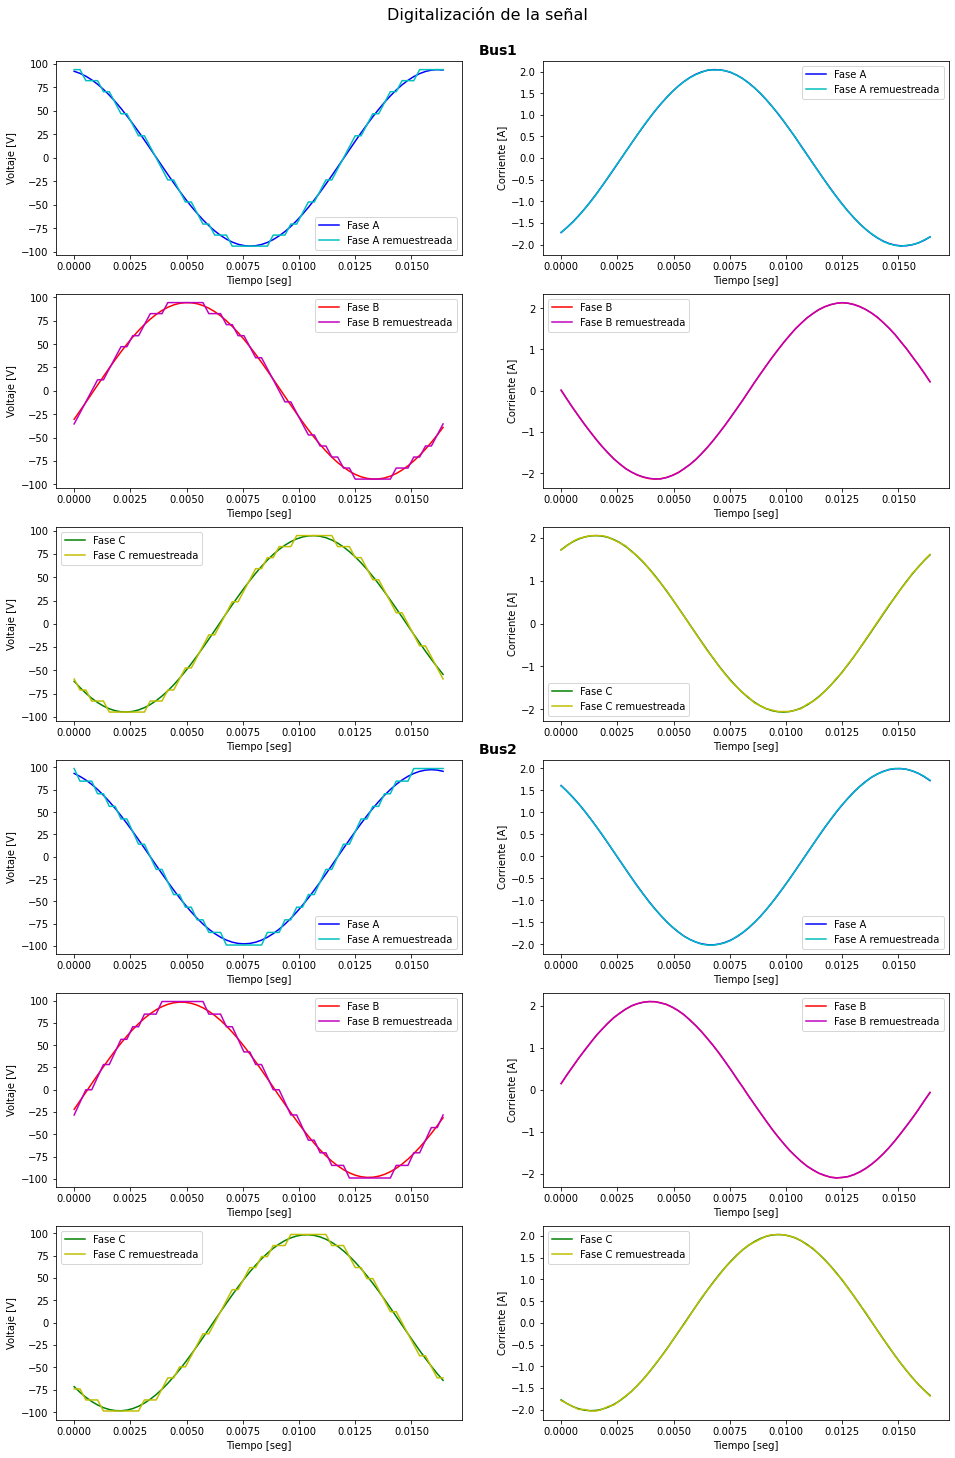

In [7]:
quantizing_bits_V = 4 # Valor típico: 12 (Voltaje)
quantizing_bits_I = 8 # Valor típico: 16 (Corriente)
dig_V_bus1_sub = np.empty(([N_tot,3]))
dig_I_bus1_sub = np.empty(([N_tot,3]))
dig_V_bus2_sub = np.empty(([N_tot,3]))
dig_I_bus2_sub = np.empty(([N_tot,3]))
for i in np.arange(6):
    if i<3:
        dig_V_bus1_sub[:,i] = quantizer(V_bus1_sub[:,i], quantizing_bits_V)
        dig_V_bus2_sub[:,i] = quantizer(V_bus2_sub[:,i], quantizing_bits_V)
    else:
        dig_I_bus1_sub[:,i-3] = quantizer(I_bus1_sub[:,i-3], quantizing_bits_I)
        dig_I_bus2_sub[:,i-3] = quantizer(I_bus2_sub[:,i-3], quantizing_bits_I)
print(N_tot)

measures_sub_dig = [dig_V_bus1_sub,dig_I_bus1_sub,dig_V_bus2_sub,dig_I_bus2_sub]
# PLOTING -----------------------------------------------------------------
f, axarr = plt.subplots(6, 2, figsize =(16, 25))
f.suptitle('Digitalización de la señal', y=0.91, fontsize=16)
colors_sub_dig =['c-','m-','y-']
cont = 0
for i in range(len(measures_sub_dig)):
    axarr.flat[0].set_title(r'$\bf{Bus 1}$',x=1.09, fontsize=14)
    axarr[3,0].set_title(r'$\bf{Bus 2}$',x=1.09, fontsize=14)
    for j in np.arange(3):
        if (cont % 2)==0: #Si es par
            p1 = np.int(cont/2)
            p2 = 0
            axarr[p1,p2].set_ylabel('Voltaje [V]')
        else:
            p1 = np.int(np.ceil(cont/2)-1)
            p2 = 1
            axarr[p1,p2].set_ylabel('Corriente [A]')
        if (i<2):
            p1 = j
            if (i%2)==0: p2=0
            else: p2=1
        else:
            p1 = j + 3
            if (i%2)==0: p2=0
            else: p2=1
        axarr[p1,p2].set_xlabel('Tiempo [seg]')
        axarr[p1,p2].plot(time_sub[:,i][0:fs_user_cycle], measures_sub[i][:,j][0:fs_user_cycle], colors[j], label=labels[j])
        axarr[p1,p2].plot(time_sub[:,i][0:fs_user_cycle], measures_sub_dig[i][:,j][0:fs_user_cycle], colors_sub_dig[j], label=labels_sub[j])
        axarr[p1,p2].legend()
        cont = cont + 1



### Etapa de Filtros Ortogonales

Inicalmente se muestran las gráficas de magnitud de las señales, mostrando el comportamiento a lo largo del tiempo del archivo COMTRADE leído previamente, y luego se muestra la variación en fase de estas mismas señales.

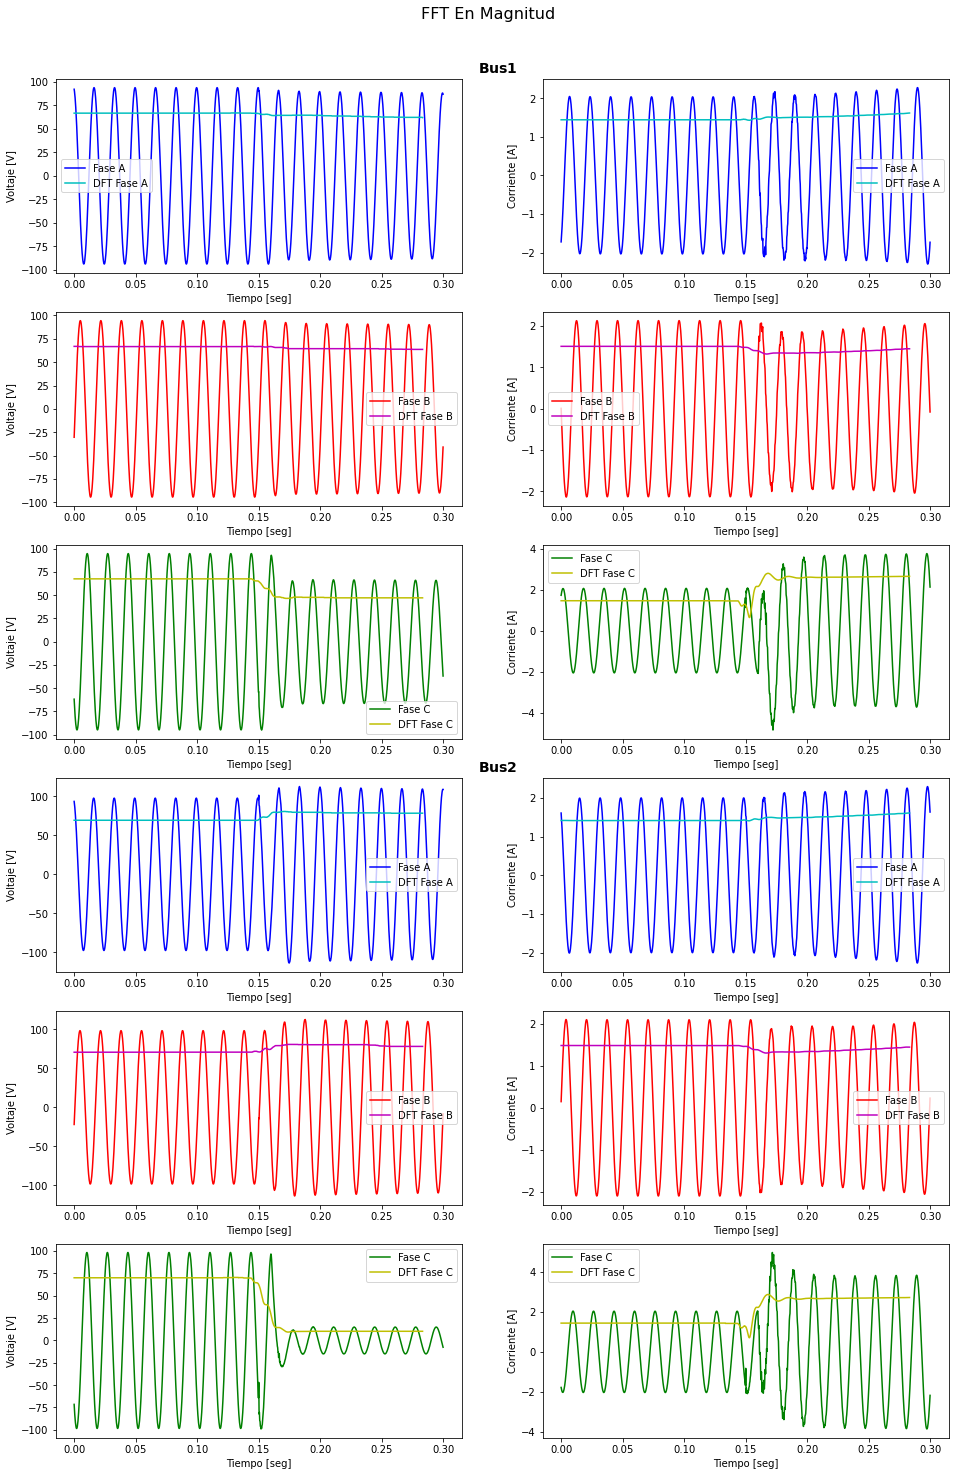

In [8]:
N_tot_DFT = N_tot-fs_user_cycle
Xc_bus1_V = np.empty(([N_tot_DFT,3]))
Xs_bus1_V = np.empty(([N_tot_DFT,3]))
Xc_bus1_I = np.empty(([N_tot_DFT,3]))
Xs_bus1_I = np.empty(([N_tot_DFT,3]))
X_bus1_V = np.empty(([N_tot_DFT,3]))
Y_bus1_V = np.empty(([N_tot_DFT,3]))
X_bus1_I = np.empty(([N_tot_DFT,3]))
Y_bus1_I = np.empty(([N_tot_DFT,3]))
#bus2
Xc_bus2_V = np.empty(([N_tot_DFT,3]))
Xs_bus2_V = np.empty(([N_tot_DFT,3]))
Xc_bus2_I = np.empty(([N_tot_DFT,3]))
Xs_bus2_I = np.empty(([N_tot_DFT,3]))
X_bus2_V = np.empty(([N_tot_DFT,3]))
Y_bus2_V = np.empty(([N_tot_DFT,3]))
X_bus2_I = np.empty(([N_tot_DFT,3]))
Y_bus2_I = np.empty(([N_tot_DFT,3]))
t = np.empty(([N_tot_DFT,6]))

for i in np.arange(6):
    if i<3:
        #BUS1
        t[:,i], Xc_bus1_V[:,i], Xs_bus1_V[:,i] = DFT(time_sub[:,i], dig_V_bus1_sub[:,i], fk, fs_user_cycle)
        for j in range(len(Xc_bus1_V)):
            z_bus1_V = complex(Xc_bus1_V[j,i],Xs_bus1_V[j,i])
            X_bus1_V[j,i], Y_bus1_V[j,i] = cmath.polar(z_bus1_V)
            Y_bus1_V[j,i] = (Y_bus1_V[j,i])*180/np.pi
            if Y_bus1_V[j,i] < 0:
                Y_bus1_V[j,i] = 360 + Y_bus1_V[j,i]
        
        #BUS2
        t[:,i], Xc_bus2_V[:,i], Xs_bus2_V[:,i] = DFT(time_sub[:,i], dig_V_bus2_sub[:,i], fk, fs_user_cycle)
        for j in range(len(Xc_bus2_V)):
            z_bus2_V = complex(Xc_bus2_V[j,i],Xs_bus2_V[j,i])
            X_bus2_V[j,i], Y_bus2_V[j,i] = cmath.polar(z_bus2_V)
            Y_bus2_V[j,i] = (Y_bus2_V[j,i])*180/np.pi
            if Y_bus2_V[j,i] < 0:
                Y_bus2_V[j,i] = 360 + Y_bus2_V[j,i]
    else:
        #BUS1
        t[:,i], Xc_bus1_I[:,i-3], Xs_bus1_I[:,i-3] = DFT(time_sub[:,i], dig_I_bus1_sub[:,i-3], fk, fs_user_cycle)
        for j in range(len(Xc_bus1_I)):
            z_bus1_I = complex(Xc_bus1_I[j,i-3],Xs_bus1_I[j,i-3])
            X_bus1_I[j,i-3], Y_bus1_I[j,i-3] = cmath.polar(z_bus1_I)
            Y_bus1_I[j,i-3] = (Y_bus1_I[j,i-3])*180/np.pi
            if Y_bus1_I[j,i-3] < 0:
                Y_bus1_I[j,i-3] = 360 + Y_bus1_I[j,i-3]
        #BUS2
        t[:,i], Xc_bus2_I[:,i-3], Xs_bus2_I[:,i-3] = DFT(time_sub[:,i], dig_I_bus2_sub[:,i-3], fk, fs_user_cycle)
        for j in range(len(Xc_bus2_V)):
            z_bus2_I = complex(Xc_bus2_I[j,i-3],Xs_bus2_I[j,i-3])
            X_bus2_I[j,i-3], Y_bus2_I[j,i-3] = cmath.polar(z_bus2_I)
            Y_bus2_I[j,i-3] = (Y_bus2_I[j,i-3])*180/np.pi
            if Y_bus2_I[j,i-3] < 0:
                Y_bus2_I[j,i-3] = 360 + Y_bus2_I[j,i-3]

measures_Xc = [Xc_bus1_V,Xc_bus1_I,Xc_bus2_V,Xc_bus2_I]
measures_Xs = [Xs_bus1_V,Xs_bus1_I,Xs_bus2_V,Xs_bus2_I]

measures_X = [X_bus1_V,X_bus1_I,X_bus2_V,X_bus2_I]
measures_Y = [Y_bus1_V,Y_bus1_I,Y_bus2_V,Y_bus2_I]
# PLOTING -----------------------------------------------------------------
f, axarr = plt.subplots(6, 2, figsize =(16, 25))
f.suptitle('FFT En Magnitud', y=0.92, fontsize=16)
labels_X = ['DFT Fase A','DFT Fase B', 'DFT Fase C']
cont = 0
for i in range(len(measures_X)):
    axarr.flat[0].set_title(r'$\bf{Bus 1}$',x=1.09, fontsize=14)
    axarr[3,0].set_title(r'$\bf{Bus 2}$',x=1.09, fontsize=14)
    for j in np.arange(3):
        if (cont % 2)==0: #Si es par
            p1 = np.int(cont/2)
            p2 = 0
            axarr[p1,p2].set_ylabel('Voltaje [V]')
        else:
            p1 = np.int(np.ceil(cont/2)-1)
            p2 = 1
            axarr[p1,p2].set_ylabel('Corriente [A]')
        if (i<2):
            p1 = j
            if (i%2)==0: p2=0
            else: p2=1
        else:
            p1 = j + 3
            if (i%2)==0: p2=0
            else: p2=1
        axarr[p1,p2].set_xlabel('Tiempo [seg]')
        axarr[p1,p2].plot(time_sub[:,i], measures_sub[i][:,j], colors[j], label=labels[j])
        axarr[p1,p2].plot(t[:,i], measures_X[i][:,j], colors_sub_dig[j], label=labels_X[j])
        axarr[p1,p2].legend()
        cont = cont + 1
        

Grafica de Fases

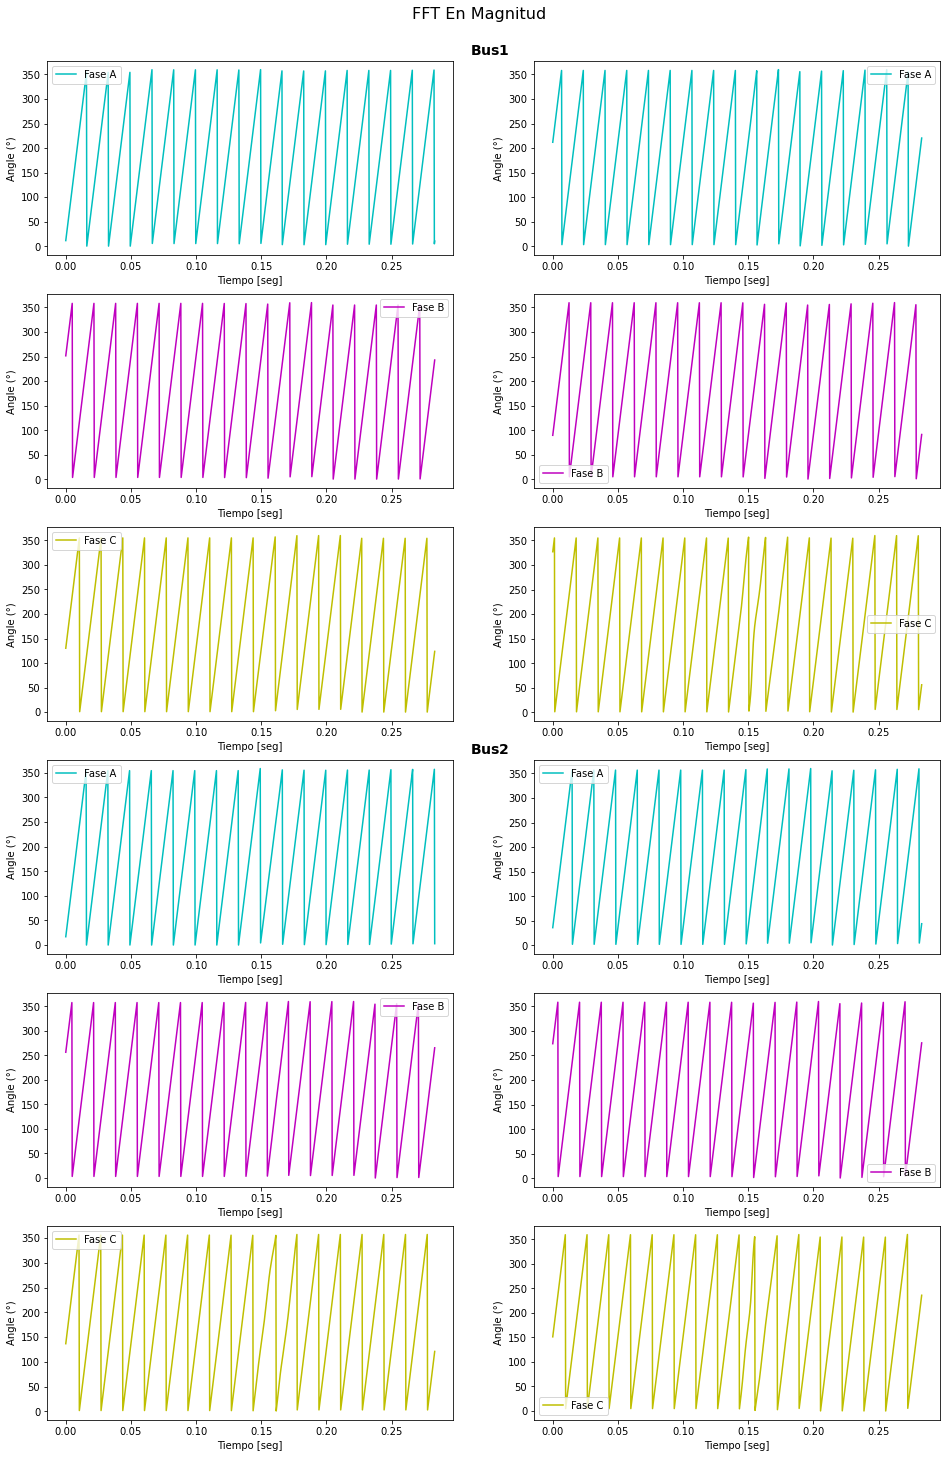

In [9]:
# PLOTING -----------------------------------------------------------------
f, axarr = plt.subplots(6, 2, figsize =(16, 25))
f.suptitle('FFT En Magnitud', y=0.91, fontsize=16)
cont = 0
for i in range(len(measures_Y)):
    axarr.flat[0].set_title(r'$\bf{Bus 1}$',x=1.09, fontsize=14)
    axarr[3,0].set_title(r'$\bf{Bus 2}$',x=1.09, fontsize=14)
    for j in np.arange(3):
        if (i<2):
            p1 = j
            if (i%2)==0: p2=0
            else: p2=1
        else:
            p1 = j + 3
            if (i%2)==0: p2=0
            else: p2=1
        axarr[p1,p2].set_xlabel('Tiempo [seg]')
        axarr[p1,p2].set_ylabel('Angle (°)')
        axarr[p1,p2].plot(t[:,i], measures_Y[i][:,j], colors_sub_dig[j], label=labels[j])
        axarr[p1,p2].legend()
        cont = cont + 1

# RESULTADOS DE FASORES

En este punto se muestra una foto del último valor de la magnitud y la fase de la señal, es decir en el momento en el que la falla ya se ha estabilizado.

**Valores de Voltaje y Corriente**

In [10]:
fase = ['A','B','C']
print('BUS 1'+'\n\n'+'Operación Normal')
# Voltajes
for i in range(len(fase)):
    print('Voltaje fase'+ fase[i]+ ':'+ "{:.2f}".format(np.double(X_bus1_V[0,i])), 'V', "{:.2f}".format(np.double(Y_bus1_V[0,i])),'°')
#Corrientes
for i in range(len(fase)):
    print('Corriente fase', fase[i], ':', "{:.2f}".format(np.double(X_bus1_I[0,i])), 'A', "{:.2f}".format(np.double(Y_bus1_I[0,i])),'°')

print('\nFalla')
# Voltajes
for i in range(len(fase)):
    print('Voltaje fase'+ fase[i]+ ':'+ "{:.2f}".format(np.double(X_bus1_V[-1,i])), 'V', "{:.2f}".format(np.double(Y_bus1_V[-1,i])),'°')
#Corrientes
for i in range(len(fase)):
    print('Corriente fase', fase[i], ':', "{:.2f}".format(np.double(X_bus1_I[-1,i])), 'A', "{:.2f}".format(np.double(Y_bus1_I[-1,i])),'°')


print('\n\nBUS 2'+'\n\n'+'Operación Normal')
# Voltaje
for i in range(len(fase)):
    print('Voltaje fase', fase[i], ':', "{:.2f}".format(np.double(X_bus2_V[0,i])), 'V', "{:.2f}".format(np.double(Y_bus2_V[0,i])),'°')
#Corriente
for i in range(len(fase)):
    print('Corriente fase', fase[i], ':', "{:.2f}".format(np.double(X_bus2_I[0,i])), 'A', "{:.2f}".format(np.double(Y_bus2_I[0,i])),'°')
    
print('\nFalla')
# Voltaje
for i in range(len(fase)):
    print('Voltaje fase', fase[i], ':', "{:.2f}".format(np.double(X_bus2_V[-1,i])), 'V', "{:.2f}".format(np.double(Y_bus2_V[-1,i])),'°')
#Corriente
for i in range(len(fase)):
    print('Corriente fase', fase[i], ':', "{:.2f}".format(np.double(X_bus2_I[-1,i])), 'A', "{:.2f}".format(np.double(Y_bus2_I[-1,i])),'°')

BUS 1

Operación Normal
Voltaje faseA:66.59 V 11.25 °
Voltaje faseB:66.92 V 251.45 °
Voltaje faseC:67.60 V 130.18 °
Corriente fase A : 1.44 A 211.85 °
Corriente fase B : 1.51 A 89.66 °
Corriente fase C : 1.46 A 327.03 °

Falla
Voltaje faseA:61.88 V 10.33 °
Voltaje faseB:63.68 V 242.84 °
Voltaje faseC:47.19 V 123.75 °
Corriente fase A : 1.62 A 220.41 °
Corriente fase B : 1.45 A 91.32 °
Corriente fase C : 2.65 A 55.79 °


BUS 2

Operación Normal
Voltaje fase A : 69.18 V 16.88 °
Voltaje fase B : 70.64 V 256.37 °
Voltaje fase C : 70.14 V 136.55 °
Corriente fase A : 1.42 A 36.14 °
Corriente fase B : 1.48 A 273.97 °
Corriente fase C : 1.43 A 151.21 °

Falla
Voltaje fase A : 78.21 V 2.70 °
Voltaje fase B : 78.09 V 265.40 °
Voltaje fase C : 10.27 V 120.94 °
Corriente fase A : 1.61 A 44.16 °
Corriente fase B : 1.45 A 275.63 °
Corriente fase C : 2.71 A 235.94 °


**Gráficas de Fasores** 

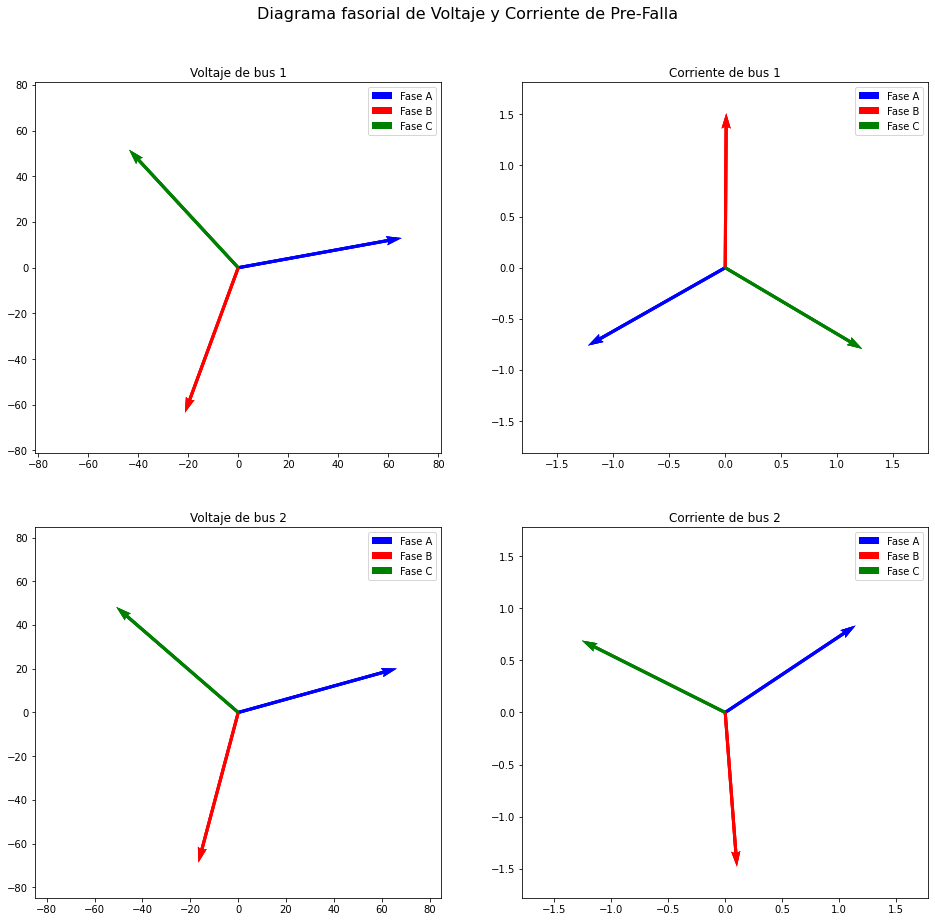

In [11]:
# Creando la figura
f, axarr = plt.subplots(2, 2, figsize =(16, 15))
f.suptitle('Diagrama fasorial de Voltaje y Corriente de Pre-Falla', y=0.95, fontsize=16)

#lim_axis_V = np.max([np.float(X_V[-1:,0]), np.float(X_V[-1:,1]),np.float(X_V[-1:,2])])
#lim_axis_C = np.max([np.float(X_C[-1:,0]), np.float(X_C[-1:,1]),np.float(X_C[-1:,2])])
#print(lim_axis_V)
# Creando el punto de origen para los vectores
x_pos = [0, 0,0] 
y_pos = [0, 0,0]

n_bus=1
for i in range(len(measures_Xc)):    
    #print(lim_axis_V)
    if (i % 2)==0: #Si es par
        p1 = np.int(i/2)
        p2 = 0
        axarr[p1,p2].set_title(('Voltaje de bus '+str(n_bus)))
        lim_axis_V = np.max([np.float(measures_X[i][0,0]), np.float(measures_X[i][0,1]),np.float(measures_X[i][0,2])])
        axarr[p1,p2].axis([-1.2*lim_axis_V, 1.2*lim_axis_V, -1.2*lim_axis_V, 1.2*lim_axis_V]) 
    else:
        p1 = np.int(np.ceil(i/2)-1)
        p2 = 1
        axarr[p1,p2].set_title(('Corriente de bus '+str(n_bus)))
        lim_axis_C = np.max([np.float(measures_X[i][0,0]), np.float(measures_X[i][0,1]),np.float(measures_X[i][0,2])])
        axarr[p1,p2].axis([-1.2*lim_axis_C, 1.2*lim_axis_C, -1.2*lim_axis_C, 1.2*lim_axis_C]) 
        n_bus=n_bus+1
        
    axarr[p1,p2].quiver(x_pos, y_pos, measures_Xc[i][0,0], measures_Xs[i][0,0], angles='xy', scale_units = 'xy', scale=1, color=['b'], label='Fase A') 
    axarr[p1,p2].quiver(x_pos, y_pos, measures_Xc[i][0,1], measures_Xs[i][0,1], angles='xy', scale_units = 'xy', scale=1, color=['r'], label='Fase B')
    axarr[p1,p2].quiver(x_pos, y_pos, measures_Xc[i][0,2], measures_Xs[i][0,2], angles='xy', scale_units = 'xy', scale=1, color=['g'], label='Fase C') 
    axarr[p1,p2].legend()


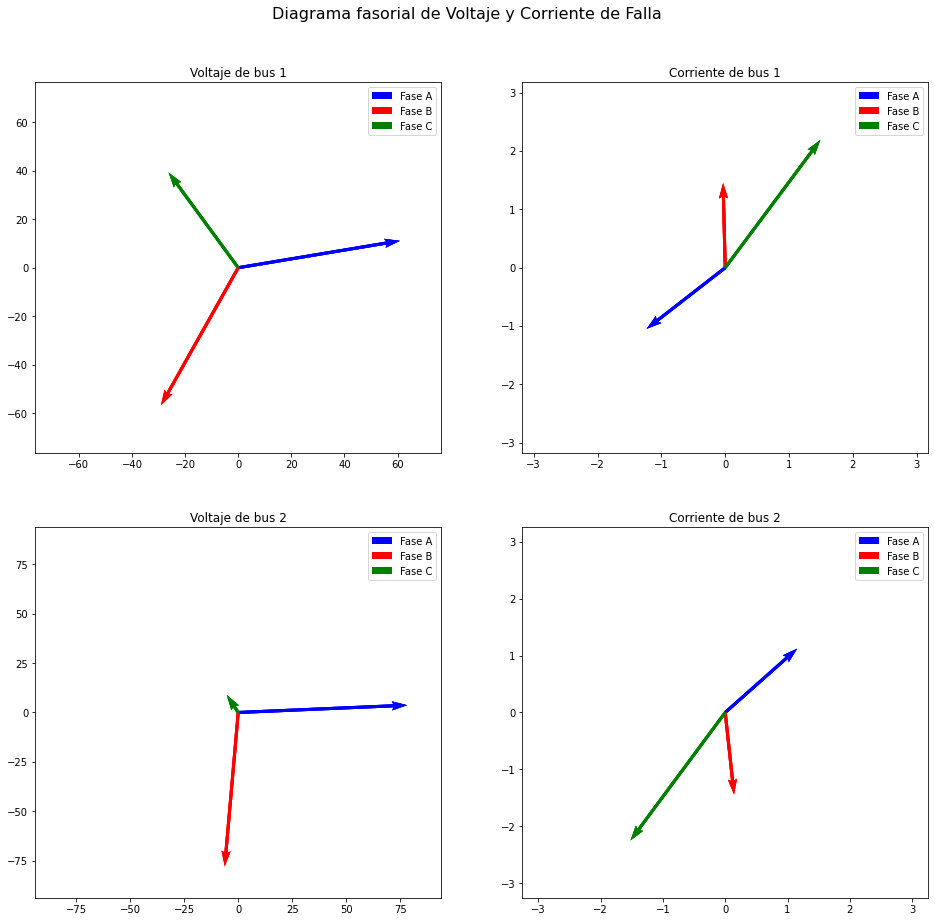

In [12]:
# Creando la figura
f, axarr = plt.subplots(2, 2, figsize =(16, 15))
f.suptitle('Diagrama fasorial de Voltaje y Corriente de Falla', y=0.95, fontsize=16)

#lim_axis_V = np.max([np.float(X_V[-1:,0]), np.float(X_V[-1:,1]),np.float(X_V[-1:,2])])
#lim_axis_C = np.max([np.float(X_C[-1:,0]), np.float(X_C[-1:,1]),np.float(X_C[-1:,2])])
#print(lim_axis_V)
# Creando el punto de origen para los vectores
x_pos = [0, 0,0] 
y_pos = [0, 0,0]

n_bus=1
for i in range(len(measures_Xc)):    
    #print(lim_axis_V)
    if (i % 2)==0: #Si es par
        p1 = np.int(i/2)
        p2 = 0
        axarr[p1,p2].set_title(('Voltaje de bus '+str(n_bus)))
        lim_axis_V = np.max([np.float(measures_X[i][-1,0]), np.float(measures_X[i][-1,1]),np.float(measures_X[i][-1,2])])
        axarr[p1,p2].axis([-1.2*lim_axis_V, 1.2*lim_axis_V, -1.2*lim_axis_V, 1.2*lim_axis_V]) 
    else:
        p1 = np.int(np.ceil(i/2)-1)
        p2 = 1
        axarr[p1,p2].set_title(('Corriente de bus '+str(n_bus)))
        lim_axis_C = np.max([np.float(measures_X[i][-1,0]), np.float(measures_X[i][-1,1]),np.float(measures_X[i][-1,2])])
        axarr[p1,p2].axis([-1.2*lim_axis_C, 1.2*lim_axis_C, -1.2*lim_axis_C, 1.2*lim_axis_C]) 
        n_bus=n_bus+1
        
    axarr[p1,p2].quiver(x_pos, y_pos, measures_Xc[i][-1,0], measures_Xs[i][-1,0], angles='xy', scale_units = 'xy', scale=1, color=['b'], label='Fase A') 
    axarr[p1,p2].quiver(x_pos, y_pos, measures_Xc[i][-1,1], measures_Xs[i][-1,1], angles='xy', scale_units = 'xy', scale=1, color=['r'], label='Fase B')
    axarr[p1,p2].quiver(x_pos, y_pos, measures_Xc[i][-1,2], measures_Xs[i][-1,2], angles='xy', scale_units = 'xy', scale=1, color=['g'], label='Fase C') 
    axarr[p1,p2].legend()
 

## Calculo de Componentes simetricas

In [13]:
def seq_general(ph):
    # Se usan las fases en valores rectangulares
    phA = ph[0]
    phB = ph[1]
    phC = ph[2]
    a = -0.5 + (np.sqrt(3)/2)*1j
    s0=(phA+phB+phC)/3
    s1=(phA+a*phB+a*a*phC)/3
    s2=(phA+a*a*phB+a*phC)/3
    #s = [s0, s1, s2]
    return s0, s1, s2

def seq_pos(s1):
    a = -0.5 + (np.sqrt(3)/2)*1j
    phA1 = s1
    phB1 = a*a*s1
    phC1 = a*s1
    ph = [phA1, phB1, phC1]
    return ph
    
def seq_neg(s2):
    a = -0.5 + (np.sqrt(3)/2)*1j
    phA2 = s2
    phB2 = a*s2
    phC2 = a*a*s2
    ph = [phA2, phB2, phC2]
    return ph


In [14]:
ph_pre = np.empty(([2,6]), dtype=complex)
ph_falla = np.empty(([2,6]), dtype=complex)
ph = ['A','B','C']
for b in range(2):
    for i in range(len(ph)):
        if b==0:
            ph_pre[b,i] = complex(Xc_bus1_V[0,i],Xs_bus1_V[0,i])
            ph_pre[b,i+3] = complex(Xc_bus1_I[0,i],Xs_bus1_I[0,i])
            ph_falla[b,i] = complex(Xc_bus1_V[-1,i],Xs_bus1_V[-1,i])
            ph_falla[b,i+3] = complex(Xc_bus1_I[-1,i],Xs_bus1_I[-1,i])
        else:
            ph_pre[b,i] = complex(Xc_bus2_V[0,i],Xs_bus2_V[0,i])
            ph_pre[b,i+3] = complex(Xc_bus2_I[0,i],Xs_bus2_I[0,i])
            ph_falla[b,i] = complex(Xc_bus2_V[-1,i],Xs_bus2_V[-1,i])
            ph_falla[b,i+3] = complex(Xc_bus2_I[-1,i],Xs_bus2_I[-1,i])

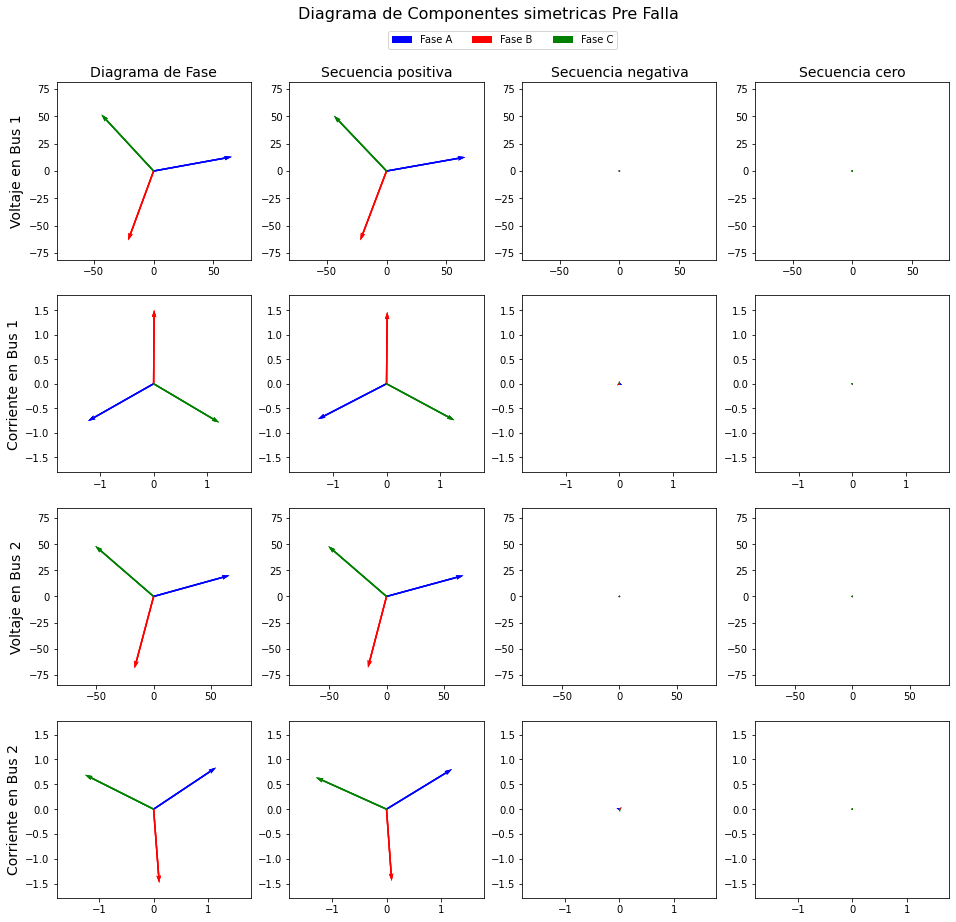

In [15]:
# Calculo de secuencias de  prefalla
V_seq_pre = np.empty(([6,4]), dtype=complex)
c = 0
for i in range(2):
    for j in range(3):
        V_seq_pre[c,0] =  ph_pre[i,j]
        c = c +1
    s0,s1,s2 = seq_general(V_seq_pre[i*3:i*3+3,0])
    V_seq_pre[i*3:i*3+3,1] = seq_pos(s1)
    V_seq_pre[i*3:i*3+3,2] = seq_pos(s2)
    V_seq_pre[i*3:i*3+3,3] = [s0,s0,s0]
    
I_seq_pre = np.empty(([6,4]), dtype=complex)
c = 0
for i in range(2):
    for j in range(3):
        I_seq_pre[c,0] =  ph_pre[i,j+3]
        c = c + 1
    s0,s1,s2 = seq_general(I_seq_pre[i*3:i*3+3,0])
    I_seq_pre[i*3:i*3+3,1] = seq_pos(s1)
    I_seq_pre[i*3:i*3+3,2] = seq_pos(s2)
    I_seq_pre[i*3:i*3+3,3] = [s0,s0,s0]

# Creando la figura
f, axarr = plt.subplots(4, 4, figsize =(16, 15))
f.suptitle('Diagrama de Componentes simetricas Pre Falla', y=0.95, fontsize=16)
# Creando el punto de origen para los vectores

x_pos = [0, 0,0] 
y_pos = [0, 0,0]
cont1 = 0
cont2 = 0
label = ['Fase A', 'Fase B', 'Fase C']
colors = ['b','r','g']
n=0
n1=0
for i in range(4):
    for k in range(3):
        if (i%2)==0:
            lim_axis_V = np.max([np.float(abs(V_seq_pre[0+3*n,0])), np.float(abs(V_seq_pre[1+3*n,0])),np.float(abs(V_seq_pre[2+3*n,0]))])
            axarr[i,0].quiver(x_pos, y_pos, V_seq_pre[cont1,0].real , V_seq_pre[cont1,0].imag, angles='xy', scale_units = 'xy', scale=1, color=colors[k], label=label[k])
            axarr[i,1].quiver(x_pos, y_pos, V_seq_pre[cont1,1].real , V_seq_pre[cont1,1].imag, angles='xy', scale_units = 'xy', scale=1, color=colors[k], label=label[k])
            axarr[i,2].quiver(x_pos, y_pos, V_seq_pre[cont1,2].real , V_seq_pre[cont1,2].imag, angles='xy', scale_units = 'xy', scale=1, color=colors[k], label=label[k])
            axarr[i,3].quiver(x_pos, y_pos, V_seq_pre[cont1,3].real , V_seq_pre[cont1,3].imag, angles='xy', scale_units = 'xy', scale=1, color=colors[k], label=label[k])
            axarr[i,0].axis([-1.2*lim_axis_V, 1.2*lim_axis_V, -1.2*lim_axis_V, 1.2*lim_axis_V])
            axarr[i,1].axis([-1.2*lim_axis_V, 1.2*lim_axis_V, -1.2*lim_axis_V, 1.2*lim_axis_V])
            axarr[i,2].axis([-1.2*lim_axis_V, 1.2*lim_axis_V, -1.2*lim_axis_V, 1.2*lim_axis_V])
            axarr[i,3].axis([-1.2*lim_axis_V, 1.2*lim_axis_V, -1.2*lim_axis_V, 1.2*lim_axis_V])
            if i==0:
                if cont1 < 3: cont1 = cont1+1
                else: cont1=0
            else:
                n = 1
                if cont1 < 6: cont1 = cont1 + 1
                else: cont1 = 3                    
        else:
            lim_axis_I = np.max([np.float(abs(I_seq_pre[0+3*n1,0])), np.float(abs(I_seq_pre[1+3*n1,0])),np.float(abs(I_seq_pre[2+3*n1,0]))])
            axarr[i,0].quiver(x_pos, y_pos, I_seq_pre[cont2,0].real , I_seq_pre[cont2,0].imag, angles='xy', scale_units = 'xy', scale=1, color=colors[k], label=label[k])
            axarr[i,1].quiver(x_pos, y_pos, I_seq_pre[cont2,1].real , I_seq_pre[cont2,1].imag, angles='xy', scale_units = 'xy', scale=1, color=colors[k], label=label[k])
            axarr[i,2].quiver(x_pos, y_pos, I_seq_pre[cont2,2].real , I_seq_pre[cont2,2].imag, angles='xy', scale_units = 'xy', scale=1, color=colors[k], label=label[k])
            axarr[i,3].quiver(x_pos, y_pos, I_seq_pre[cont2,3].real , I_seq_pre[cont2,3].imag, angles='xy', scale_units = 'xy', scale=1, color=colors[k], label=label[k])
            axarr[i,0].axis([-1.2*lim_axis_I, 1.2*lim_axis_I, -1.2*lim_axis_I, 1.2*lim_axis_I])
            axarr[i,1].axis([-1.2*lim_axis_I, 1.2*lim_axis_I, -1.2*lim_axis_I, 1.2*lim_axis_I])
            axarr[i,2].axis([-1.2*lim_axis_I, 1.2*lim_axis_I, -1.2*lim_axis_I, 1.2*lim_axis_I])
            axarr[i,3].axis([-1.2*lim_axis_I, 1.2*lim_axis_I, -1.2*lim_axis_I, 1.2*lim_axis_I])
            if i==1:
                if cont2 < 3: cont2 = cont2+1
                else: cont2=0
            else:
                n1 = 1
                if cont2 < 6: cont2 = cont2 + 1
                else: cont2 = 3  
            
axarr[0,0].set_ylabel('Voltaje en Bus 1',fontsize=14)
axarr[1,0].set_ylabel('Corriente en Bus 1',fontsize=14)
axarr[2,0].set_ylabel('Voltaje en Bus 2',fontsize=14)
axarr[3,0].set_ylabel('Corriente en Bus 2',fontsize=14)
axarr[0,0].set_title('Diagrama de Fase',fontsize=14)
axarr[0,1].set_title('Secuencia positiva',fontsize=14)
axarr[0,2].set_title('Secuencia negativa',fontsize=14)
axarr[0,3].set_title('Secuencia cero',fontsize=14)

f.legend(axarr[0,0].get_children(), label, ncol=5, bbox_to_anchor=(0.54, 0.83))

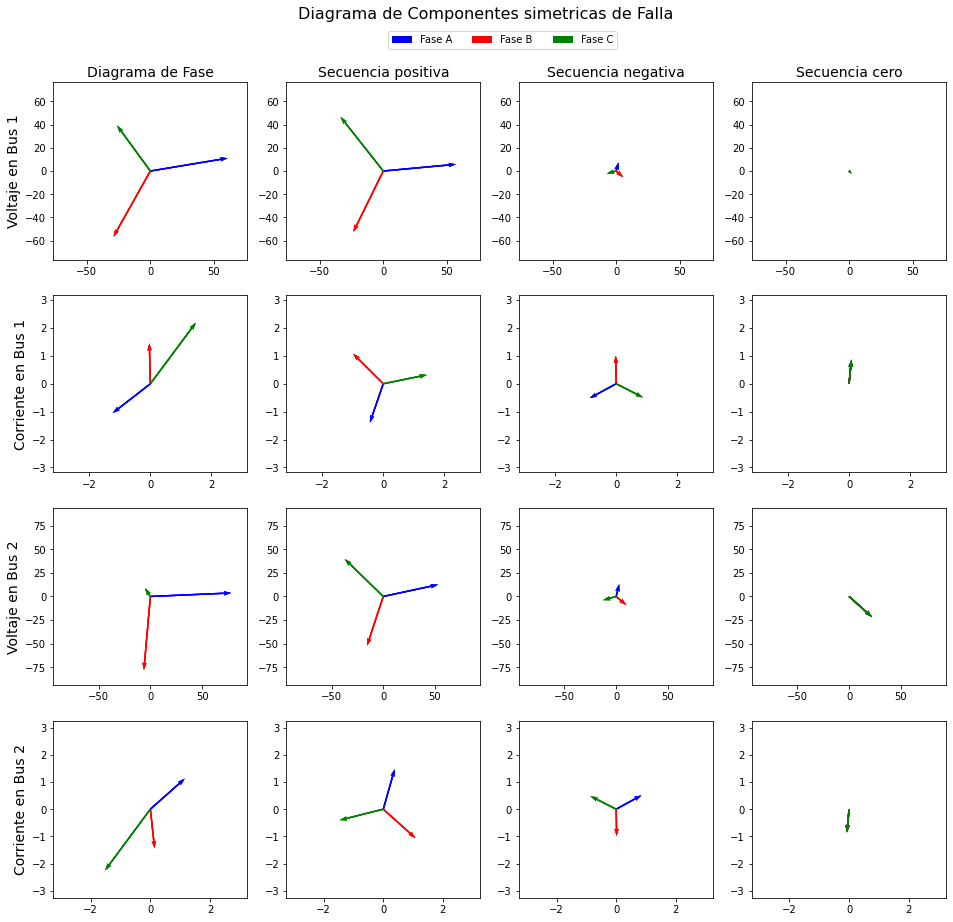

In [16]:
# Calculo de secuencias de  prefalla
V_seq_falla = np.empty(([6,4]), dtype=complex)
c = 0
for i in range(2):
    for j in range(3):
        V_seq_falla[c,0] =  ph_falla[i,j]
        c = c +1
    s0,s1,s2 = seq_general(V_seq_falla[i*3:i*3+3,0])
    V_seq_falla[i*3:i*3+3,1] = seq_pos(s1)
    V_seq_falla[i*3:i*3+3,2] = seq_pos(s2)
    V_seq_falla[i*3:i*3+3,3] = [s0,s0,s0]
    
I_seq_falla = np.empty(([6,4]), dtype=complex)
c = 0
for i in range(2):
    for j in range(3):
        I_seq_falla[c,0] =  ph_falla[i,j+3]
        c = c + 1
    s0,s1,s2 = seq_general(I_seq_falla[i*3:i*3+3,0])
    I_seq_falla[i*3:i*3+3,1] = seq_pos(s1)
    I_seq_falla[i*3:i*3+3,2] = seq_pos(s2)
    I_seq_falla[i*3:i*3+3,3] = [s0,s0,s0]

# Creando la figura
f, axarr = plt.subplots(4, 4, figsize =(16, 15))
f.suptitle('Diagrama de Componentes simetricas de Falla', y=0.95, fontsize=16)
# Creando el punto de origen para los vectores

x_pos = [0, 0,0] 
y_pos = [0, 0,0]
cont1 = 0
cont2 = 0
label = ['Fase A', 'Fase B', 'Fase C']
colors = ['b','r','g']
n=0
n1=0
for i in range(4):
    for k in range(3):
        if (i%2)==0:
            lim_axis_V = np.max([np.float(abs(V_seq_falla[0+3*n,0])), np.float(abs(V_seq_falla[1+3*n,0])),np.float(abs(V_seq_falla[2+3*n,0]))])
            axarr[i,0].quiver(x_pos, y_pos, V_seq_falla[cont1,0].real , V_seq_falla[cont1,0].imag, angles='xy', scale_units = 'xy', scale=1, color=colors[k], label=label[k])
            axarr[i,1].quiver(x_pos, y_pos, V_seq_falla[cont1,1].real , V_seq_falla[cont1,1].imag, angles='xy', scale_units = 'xy', scale=1, color=colors[k], label=label[k])
            axarr[i,2].quiver(x_pos, y_pos, V_seq_falla[cont1,2].real , V_seq_falla[cont1,2].imag, angles='xy', scale_units = 'xy', scale=1, color=colors[k], label=label[k])
            axarr[i,3].quiver(x_pos, y_pos, V_seq_falla[cont1,3].real , V_seq_falla[cont1,3].imag, angles='xy', scale_units = 'xy', scale=1, color=colors[k], label=label[k])
            axarr[i,0].axis([-1.2*lim_axis_V, 1.2*lim_axis_V, -1.2*lim_axis_V, 1.2*lim_axis_V])
            axarr[i,1].axis([-1.2*lim_axis_V, 1.2*lim_axis_V, -1.2*lim_axis_V, 1.2*lim_axis_V])
            axarr[i,2].axis([-1.2*lim_axis_V, 1.2*lim_axis_V, -1.2*lim_axis_V, 1.2*lim_axis_V])
            axarr[i,3].axis([-1.2*lim_axis_V, 1.2*lim_axis_V, -1.2*lim_axis_V, 1.2*lim_axis_V])
            if i==0:
                if cont1 < 3: cont1 = cont1+1
                else: cont1=0
            else:
                n=1
                if cont1 < 6: cont1 = cont1 + 1
                else: cont1 = 3                    
        else:
            lim_axis_I = np.max([np.float(abs(I_seq_falla[0+3*n1,0])), np.float(abs(I_seq_falla[1+3*n1,0])),np.float(abs(I_seq_falla[2+3*n1,0]))])
            axarr[i,0].quiver(x_pos, y_pos, I_seq_falla[cont2,0].real , I_seq_falla[cont2,0].imag, angles='xy', scale_units = 'xy', scale=1, color=colors[k], label=label[k])
            axarr[i,1].quiver(x_pos, y_pos, I_seq_falla[cont2,1].real , I_seq_falla[cont2,1].imag, angles='xy', scale_units = 'xy', scale=1, color=colors[k], label=label[k])
            axarr[i,2].quiver(x_pos, y_pos, I_seq_falla[cont2,2].real , I_seq_falla[cont2,2].imag, angles='xy', scale_units = 'xy', scale=1, color=colors[k], label=label[k])
            axarr[i,3].quiver(x_pos, y_pos, I_seq_falla[cont2,3].real , I_seq_falla[cont2,3].imag, angles='xy', scale_units = 'xy', scale=1, color=colors[k], label=label[k])
            axarr[i,0].axis([-1.2*lim_axis_I, 1.2*lim_axis_I, -1.2*lim_axis_I, 1.2*lim_axis_I])
            axarr[i,1].axis([-1.2*lim_axis_I, 1.2*lim_axis_I, -1.2*lim_axis_I, 1.2*lim_axis_I])
            axarr[i,2].axis([-1.2*lim_axis_I, 1.2*lim_axis_I, -1.2*lim_axis_I, 1.2*lim_axis_I])
            axarr[i,3].axis([-1.2*lim_axis_I, 1.2*lim_axis_I, -1.2*lim_axis_I, 1.2*lim_axis_I])
            if i==1:
                if cont2 < 3: cont2 = cont2+1
                else: cont2=0
            else:
                n1=1
                if cont2 < 6: cont2 = cont2 + 1
                else: cont2 = 3  
            
axarr[0,0].set_ylabel('Voltaje en Bus 1',fontsize=14)
axarr[1,0].set_ylabel('Corriente en Bus 1',fontsize=14)
axarr[2,0].set_ylabel('Voltaje en Bus 2',fontsize=14)
axarr[3,0].set_ylabel('Corriente en Bus 2',fontsize=14)
axarr[0,0].set_title('Diagrama de Fase',fontsize=14)
axarr[0,1].set_title('Secuencia positiva',fontsize=14)
axarr[0,2].set_title('Secuencia negativa',fontsize=14)
axarr[0,3].set_title('Secuencia cero',fontsize=14)

f.legend(axarr[0,0].get_children(), label, ncol=5, bbox_to_anchor=(0.54, 0.83))

In [17]:
phA = ph_falla[0,3]
phB = ph_falla[0,4]
phC = ph_falla[0,5]
algo = [phA,phB,phC]
s0,s1,s2 = seq_general(algo)

r0, th0 = cmath.polar(s0)
r1, th1 = cmath.polar(s1)
r2, th2 = cmath.polar(s2)

print('Secuencia positiva: {:.2f} ang {:.2f}°'.format(r1,th1*180/np.pi))
print('Secuencia negativa: {:.2f} ang {:.2f}°'.format(r2,th2*180/np.pi))
print('Secuencia cero: {:.2f} ang {:.2f}°'.format(r0,th0*180/np.pi))

Secuencia positiva: 1.46 ang -107.47°
Secuencia negativa: 1.01 ang -149.21°
Secuencia cero: 0.87 ang 85.04°


In [18]:
th2_off = th2 - th1
th1_off = th1 - th1

print('Figura a: ',(th2_off-th1_off)*180/np.pi)

if r0>0.02:
    th2_off = th2 - th0
    th0_off = th0 - th0

    print('Figura b: ',(th2_off - th0_off)*180/np.pi)

Figura a:  -41.73683805265948
Figura b:  -234.25308751738245


In [19]:
# se crea las etiquetas para la comparación entre positiva y negativa
def pos_neg():
    etiqueta_pos_neg = [{'AG'},{'AB','ABG'},{'BG'},{'BC','BCG'},{'CG'},{'AC','ACG'}]

    grupos_pos_neg = [set()]*12
    fallas_pos_neg = np.empty(([12,2]))
    c = 0
    for i in range(len(fallas_pos_neg)):
        if (i%2)==0:
            grupos_pos_neg[i] = etiqueta_pos_neg[c] 
            if i==0:
                fallas_pos_neg[i,0:2] = [340,20]
            else:
                fallas_pos_neg[i,0:2] = [fallas_pos_neg[i-1,1],fallas_pos_neg[i-1,1]+40]
            c=c+1
        else:
            fallas_pos_neg[i,0:2] = [fallas_pos_neg[i-1,1],fallas_pos_neg[i-1,1]+20]
            if c<len(etiqueta_pos_neg):
                grupos_pos_neg[i] = etiqueta_pos_neg[c].union(grupos_pos_neg[i-1])
            else:
                grupos_pos_neg[i] = grupos_pos_neg[i-1].union(etiqueta_pos_neg[0])
    return grupos_pos_neg, fallas_pos_neg

In [20]:
# se crea las etiquetas para la comparación entre cero y negativa 
def cero_neg():
    etiqueta_cero_neg = [{'AG','BCG'},{'CG','ABG'},{'BG','ACG'}]

    grupos_cero_neg = [set()]*6
    fallas_cero_neg = np.empty(([6,2]))
    c = 0
    for i in range(len(fallas_cero_neg)):
        if (i%2)==0:
            grupos_cero_neg[i] = etiqueta_cero_neg[c] 
            if i==0:
                fallas_cero_neg[i,0:2] = [315,45]
            else:
                fallas_cero_neg[i,0:2] = [fallas_cero_neg[i-1,1],fallas_cero_neg[i-1,1]+90]
            c=c+1
        else:
            fallas_cero_neg[i,0:2] = [fallas_cero_neg[i-1,1],fallas_cero_neg[i-1,1]+30]
            if c<len(etiqueta_cero_neg):
                grupos_cero_neg[i] = etiqueta_cero_neg[c].union(grupos_cero_neg[i-1])
            else:
                grupos_cero_neg[i] = grupos_cero_neg[i-1].union(etiqueta_cero_neg[0])
    return grupos_cero_neg, fallas_cero_neg

In [21]:
def tipo_falla(s0,s1,s2):
    r0, th0 = cmath.polar(s0)
    r1, th1 = cmath.polar(s1)
    r2, th2 = cmath.polar(s2)
    
    grupos_pos_neg, fallas_pos_neg = pos_neg()
    grupos_cero_neg, fallas_cero_neg = cero_neg()
    if r2 < 0.25:
        type_f={'ABC'}
    else:
        if r0 > 0.02:
            grupo_mo = {'AG','BG','CG'}
            # Verificación cero-negativa
            th2_off = th2 - th0
            th0_off = th0 - th0
            des0 = (th2_off - th0_off)*180/np.pi
            if des0<0: des0 = 360+des0
            for i in range(len(fallas_cero_neg)):
                if des0>340 or des0<=20:
                    sel1=grupos_cero_neg[0]
                elif i!=0 and des0>fallas_cero_neg[i,0] and des0<=fallas_cero_neg[i,1]:
                    sel1=grupos_cero_neg[i]
            # Verificacion positiva-negativa
            th2_off = th2 - th1
            th1_off = th1 - th1
            des1 = (th2_off-th1_off)*180/np.pi
            if des1<0: des1 = 360+des1
            for i in range(len(fallas_pos_neg)):
                if des1>340 or des1<=20:
                    sel2=grupos_pos_neg[0]
                elif i!=0 and des1>fallas_pos_neg[i,0] and des1<=fallas_pos_neg[i,1]:
                    sel2=grupos_pos_neg[i]
            type_f = sel1.intersection(sel2)
            if type_f == set():
                type_f = sel1.intersection(grupo_mo)
        else:
            grupo_bi = {'AB','BC','AC'}
            th2_off = th2 - th1
            th1_off = th1 - th1
            des1 = (th2_off-th1_off)*180/np.pi
            if des1<0: des0 = 360+des0
            for i in range(len(fallas_pos_neg)):
                if des1>340 or des1<=20:
                    sel=(grupos_pos_neg[0])
                elif i!=0 and des1>fallas_pos_neg[i,0] and des1<=fallas_pos_neg[i,1]:
                    sel=(grupos_pos_neg[i])
            type_f = sel.intersection(grupo_bi)
    return type_f

In [22]:
# Detección del tipo de falla
ph_I = ph_falla[1,3:6]
s0_I,s1_I,s2_I = seq_general(ph_I)
tipo = tipo_falla(s0_I,s1_I,s2_I)
print(tipo)

#Calculo de voltaje de secuencia
ph_V = ph_falla[1,0:3]
s0_V,s1_V,s2_V = seq_general(ph_V)

#voltaje y corriente de fase
Va,Vb,Vc = ph_falla[1,0:3]
Ia,Ib,Ic = ph_falla[1,3:6]

{'CG'}


## Cálculo de impedancia

In [23]:
def default():
    return 'No es ninguna'
def ABC(s1_V,s1_I):
    return (s1_V/s1_I)

def LL(v1,v2,i1,i2):
    return (v1-v2)/(i1-i2)

def LG(v,i,k0,s0_I,k0m):
    z = v/(i+k0*3*s0_I+k0m*s0_I)
    return z
    
def switch(case,s0_V,s1_V,s2_V,s0_I,s1_I,s2_I,Va,Vb,Vc,Ia,Ib,Ic,k0,k0m):
   sw = {1:ABC(s1_V,s1_I),
         2:LG(Va,Ia,k0,s0_I,k0m),
         3:LG(Vb,Ib,k0,s0_I,k0m),
         4:LG(Vc,Ic,k0,s0_I,k0m),
         5:'ABG',
         6:'BCG',
         7:'ACG',
         8:LL(Va,Vb,Ia,Ib),
         9:LL(Vb,Vc,Ib,Ic),
         10:LL(Va,Vc,Ia,Ic), 
        }
   return sw.get(case, default())

In [24]:
# Datos y cálculos adicionales
# Inicializando la data
L = 45 # Line Total Length 
R1L = 0.0924 #[ohm/mille]
X1L = 0.649 #[ohm/mille]
R0L = 0.0924 #[ohm/mille]
X0L = 0.649 #[ohm/mille]
R0M = 0.267 #[ohm/mille]
X0M = 1.5 #[ohm/mille]

Z1L = complex(R1L*L, X1L*L)
Z0L = complex(R0L*L, X0L*L)
Z0M = complex(R0M*L,X0M*L)

k0 = (Z0L-Z1L)/(3*Z1L)
k0m = Z0M/Z1L

# Se crea el conjunto de fallas
tipos_fallas = [{'ABC'},{'AG'},{'BG'},{'CG'},{'ABG'},{'BCG'},{'ACG'},{'AB'},{'BC'},{'AC'}]

imp = 0
for i in range(len(tipos_fallas)):
    if tipo == tipos_fallas[i]:
        imp = switch(i+1,s0_V,s1_V,s2_V,s0_I,s1_I,s2_I,Va,Vb,Vc,Ia,Ib,Ic,k0,k0m)
        
print(imp)

(-1.3320779148791626-1.804118264892248j)


## Diagrama de impedancia Mho

In [25]:
def zones_plot(Z1L, zone1, zone2, Z):
    r_1L, th_1L = cmath.polar(Z1L)
    r , th = cmath.polar(Z)
    fig, ax = plt.subplots(1, 1, figsize =(6, 6))
    fig.suptitle('Diagrama de impedancia para relé de característica Mho', y=0.95, fontsize=16)
    
    r1=r_1L*zone1
    r2=r_1L*zone2
    #theta = np.linspace(0, 2*np.pi, 360)
    #x1 = r*np.cos(theta)
    #x2 = r*np.sin(theta)
    
    #ax.plot(x1,x2,'k--')
    
    # Creando el punto de origen para los vectores
    x_pos = [0, 0,0] 
    y_pos = [0, 0,0]
    
    x_Z1L = Z1L.real
    y_Z1L = Z1L.imag
    
    x_Z = Z.real
    y_Z = Z.imag
    
    ax.set(xlim=(-r1*2, r1*2), ylim = (-r1*2, r1*2))

    a_circle = plt.Circle((x_Z1L*zone1/2, y_Z1L*zone1/2), r1/2, fill = False, linestyle= '--', edgecolor = 'r')
    ax.add_artist(a_circle)
    
    a_circle2 = plt.Circle((x_Z1L*zone2/2, y_Z1L*zone2/2), r2/2, fill = False, linestyle= '--', edgecolor = 'g')
    ax.add_artist(a_circle2)
    
    ax.quiver(x_pos, y_pos, x_Z1L, y_Z1L, angles='xy', scale_units = 'xy', scale=1, color=['k'], label=r'$Z_{Line}$')
    #ax.quiver(x_pos, y_pos, x_Z, y_Z, angles='xy', scale_units = 'xy', scale=1, color=['b'], label=r'$\bar{Z}$')
    ax.plot(x_Z, y_Z, 'b*', label=r'$\bar{Z}$')
    
    plt.text(-r_1L/10, r_1L*zone1+r_1L/10, r'$Z_1$', {'color': 'red', 'fontsize': 12}, rotation=0, horizontalalignment='center', verticalalignment='top',
         multialignment='center')
    plt.text(-r_1L/10, r_1L*zone2+r_1L/10, r'$Z_2$', {'color': 'green', 'fontsize': 12}, rotation=0, horizontalalignment='center', verticalalignment='top',
         multialignment='center')
    
    #Create broken lines
    x=np.linspace(start=-r1*2,stop=r1*2,num=30)
    plt.scatter(x,[0]*len(x), marker='_',color='k')
    plt.scatter([0]*len(x), x, marker='|',color='k')
    
    plt.xlabel('R')
    plt.ylabel('X')
    plt.legend()

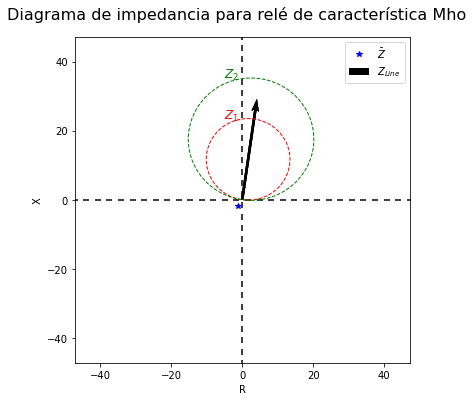

In [26]:
#print(phase(Z))
zone1= 0.8
zone2=1.2
zones_plot(Z1L, zone1, zone2, imp)

In [27]:
abs(imp)/abs(Z1L)

0.07602175370568147

# Borrador

66.58501448071125


(-81.11495286517594, 81.11495286517594, -81.11495286517594, 81.11495286517594)

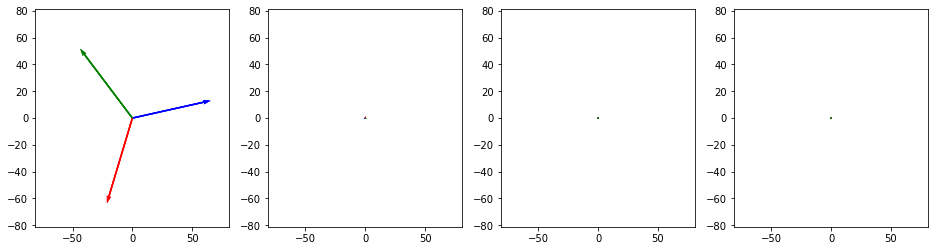

In [28]:
phA = ph_pre[0,3]
phB = ph_pre[0,4]
phC = ph_pre[0,5]
algo = [phA,phB,phC]
s0,s1,s2 = seq_general(algo)
[phA1, phB1, phC1]= seq_pos(s1)
[phA2, phB2, phC2]= seq_neg(s2)

print(abs(ph_pre[0,0]))
fig, axarr = plt.subplots(1, 4, figsize =(16, 4))
axarr[0].quiver(x_pos, y_pos, ph_pre[0,0].real , ph_pre[0,0].imag, angles='xy', scale_units = 'xy', scale=1, color=['b'], label='Fase A')
axarr[0].quiver(x_pos, y_pos, ph_pre[0,1].real , ph_pre[0,1].imag, angles='xy', scale_units = 'xy', scale=1, color=['r'], label='Fase B')
axarr[0].quiver(x_pos, y_pos, ph_pre[0,2].real , ph_pre[0,2].imag, angles='xy', scale_units = 'xy', scale=1, color=['g'], label='Fase C')
lim_axis_V = np.max([np.float(abs(ph_pre[0,0])), np.float(abs(ph_pre[0,1])),np.float(abs(ph_pre[0,2]))])
axarr[0].axis([-1.2*lim_axis_V, 1.2*lim_axis_V, -1.2*lim_axis_V, 1.2*lim_axis_V]) 

axarr[1].quiver(x_pos, y_pos, phA1.real , phA1.imag, angles='xy', scale_units = 'xy', scale=1, color=['b'], label='Fase A')
axarr[1].quiver(x_pos, y_pos, phB1.real , phB1.imag, angles='xy', scale_units = 'xy', scale=1, color=['r'], label='Fase B')
axarr[1].quiver(x_pos, y_pos, phC1.real , phC1.imag, angles='xy', scale_units = 'xy', scale=1, color=['g'], label='Fase C')
#lim_axis_V = np.max([np.float(abs(phA1)), np.float(abs(phB1)),np.float(abs(phC1))])
axarr[1].axis([-1.2*lim_axis_V, 1.2*lim_axis_V, -1.2*lim_axis_V, 1.2*lim_axis_V]) 

axarr[2].quiver(x_pos, y_pos, phA2.real , phA2.imag, angles='xy', scale_units = 'xy', scale=1, color=['b'], label='Fase A')
axarr[2].quiver(x_pos, y_pos, phB2.real , phB2.imag, angles='xy', scale_units = 'xy', scale=1, color=['r'], label='Fase B')
axarr[2].quiver(x_pos, y_pos, phC2.real , phC2.imag, angles='xy', scale_units = 'xy', scale=1, color=['g'], label='Fase C')
#lim_axis_V = np.max([np.float(abs(phA2)), np.float(abs(phB2)),np.float(abs(phC2))])
axarr[2].axis([-1.2*lim_axis_V, 1.2*lim_axis_V, -1.2*lim_axis_V, 1.2*lim_axis_V]) 

axarr[3].quiver(x_pos, y_pos, s0.real , s0.imag, angles='xy', scale_units = 'xy', scale=1, color=['b'], label='Fase A')
axarr[3].quiver(x_pos, y_pos, s0.real , s0.imag, angles='xy', scale_units = 'xy', scale=1, color=['r'], label='Fase B')
axarr[3].quiver(x_pos, y_pos, s0.real , s0.imag, angles='xy', scale_units = 'xy', scale=1, color=['g'], label='Fase C')
#lim_axis_V = np.max([np.float(abs(s0)), np.float(abs(s0)),np.float(abs(s0))])
axarr[3].axis([-1.2*lim_axis_V, 1.2*lim_axis_V, -1.2*lim_axis_V, 1.2*lim_axis_V]) 

## Cálculo de la impedancia de carga

In [29]:
Z_bus1_mag = np.empty(([1,3]))
Z_bus1_ang = np.empty(([1,3]))
Z_bus2_mag = np.empty(([1,3]))
Z_bus2_ang = np.empty(([1,3]))
ph=Z_bus1_mag.shape[1]
for i in range(ph):
    Z_bus1_mag[0,i], Z_bus1_ang[0,i] = cmath.polar(complex(Xc_bus1_V[0,i],Xs_bus1_V[0,i])/complex(Xc_bus1_I[0,i],Xs_bus1_I[0,i]))
    Z_bus2_mag[0,i], Z_bus2_ang[0,i] = cmath.polar(complex(Xc_bus2_V[0,i],Xs_bus2_V[0,i])/complex(Xc_bus2_I[0,i],Xs_bus2_I[0,i]))
    
print(Z_bus1_mag, ' - ', Z_bus1_ang)
print(Z_bus2_mag, ' - ', Z_bus2_ang)

[[46.20410437 44.34225972 46.38992543]]  -  [[2.78204402 2.82376446 2.84742956]]
[[48.86327728 47.60707678 48.88844058]]  -  [[-0.33618202 -0.30706661 -0.25587492]]
